In [18]:
from xml.dom import minidom
from urllib.request import urlopen
from urllib.request import urlretrieve

## Download all nc files (can take a while)

In [7]:
url = 'https://dapds00.nci.org.au/thredds/catalog/fx3/gbr1_2.0/catalog.xml'


In [19]:
def get_elements(url, tag_name, attribute_name):
    """Get elements from an XML file"""
    # usock = urllib2.urlopen(url)
    usock = urlopen(url)
    xmldoc = minidom.parse(usock)
    usock.close()
    tags = xmldoc.getElementsByTagName(tag_name)
    attributes=[]
    for tag in tags:
        attribute = tag.getAttribute(attribute_name)
        attributes.append(attribute)
    return attributes
 

catalog = get_elements(url,'dataset','urlPath')
files=[]
for citem in catalog:
    if (citem[-3:]=='.nc'):
        files.append(citem)

count = 0
for f in files:
    count +=1
    file_url = 'https://dapds00.nci.org.au/thredds/' + 'fileServer/' + f
    file_prefix = file_url.split('/')[-1][:-3]
    file_name = file_prefix + '_' + str(count) + '.nc'
    print('Downloaing file %d of %d' % (count,len(files)))
    print(file_name)
    a = urlretrieve(file_url,file_name)
    print(a)


## Get a subset of data and load into python and save

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from siphon import catalog, ncss
import datetime

url = 'https://dapds00.nci.org.au/thredds/catalog/fx3/gbr1_2.0/catalog.xml'
tds = catalog.TDSCatalog(url)
dts = tds.datasets


In [81]:
import xarray as xr

def get_data(dataset, bbox, var):
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.lonlat_box(north=bbox[0],south=bbox[1],east=bbox[2],west=bbox[3])
    query.variables(*var)

    data = nc.get_data(query)
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
    return ds

bbox = [10,-12,147,144]#select box
var = ['temp','u','v']#select var

# for time, change the i indices, right now, it gets all first time indices
for i in range(1,10):#range(1,len(dts)+1):
    ds = get_data(dts[i],bbox,var)
    if i != 1:
        data = xr.concat([data,ds],dim = 'time')
    else:
        data = ds
    print(str(i) + '/ ' + str(len(dts)+1)) 
    
# fix dimensions    
data['longitude'] = data.longitude[1,:]
data['latitude'] = data.latitude[:,1]
data = data.swap_dims({'j':'latitude','i':'longitude','k':'zc'})    
    
data


1/ 2342
2/ 2342
3/ 2342
4/ 2342
5/ 2342
6/ 2342
7/ 2342
8/ 2342
9/ 2342


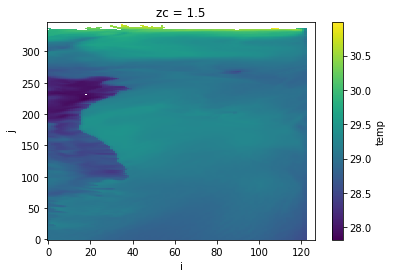

In [31]:
data.temp.isel(zc = -1).mean(dim = 'time').plot()

In [6]:
#save as nc
data.to_netcdf('example.nc')